In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import keras
import matplotlib.pyplot as plt

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


In [2]:
data_dir = './data/'

In [3]:
# Load in data
train = pd.read_csv(os.path.join(data_dir,'train.csv'))
test = pd.read_csv(os.path.join(data_dir,'test.csv'))
sample_submission = pd.read_csv(os.path.join(data_dir,'sample_submission.csv'))

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Xtrain = train.iloc[:,1:].values.astype('float32')
real_Xtest = test.values.astype('float32')
Xtrain /= 255.0
real_Xtest /= 255.0
ytrain = keras.utils.np_utils.to_categorical(train.label.values)

In [5]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(Xtrain,ytrain,test_size=0.1,random_state=42)

split_size = int(Xtrain.shape[0]*0.77)

Xtrain, Xval = Xtrain[:split_size], Xtrain[split_size:]

ytrain, yval = ytrain[:split_size], ytrain[split_size:]

In [6]:
Xtrain.shape,Xval.shape,Xtest.shape

((29106L, 784L), (8694L, 784L), (4200L, 784L))

# Model building

###  Model achitecture: 5 FC layers (500 neurons in each)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [8]:
input_units = 786
hidden_units = 500
output_units = 10
epochs = 20
batch_size = 1000

In [9]:
# Build models with 5 hidden layers achitecture
def create_fc_model(input_units=500,hidden_units=500,output_units=10,activation='sigmoid'):
    model = Sequential()
    model.add(Dense(hidden_units,activation=activation,input_shape=(input_units,)))
    model.add(Dense(hidden_units,activation=activation))
    model.add(Dense(hidden_units,activation=activation))
    model.add(Dense(hidden_units,activation=activation))
    model.add(Dense(hidden_units,activation=activation))
    model.add(Dense(output_units,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model    

In [10]:
def model_init(model,input_units=500,hidden_units=500,num_hidden=5,w_value='zero',w_scaling=1):
    w1_init = params_init((input_units,hidden_units),value=w_value,scaling=w_scaling)
    b1_init = params_init((hidden_units,),value='zero')
    model.get_layer(index=1).set_weights([w1_init,b1_init])
    w2_init = params_init((hidden_units,hidden_units),value=w_value,scaling=w_scaling)
    b2_init = params_init((hidden_units,),value='zero')

    for i in range(1,num_hidden):
        model.get_layer(index=i+1).set_weights([w2_init,b2_init])   

def params_init(shape,value='zero',scaling=1.0):
    '''initilize parameters such as weights or biases to zeros or random normal multiplied with a scaling factor'''
    if value == 'zero':
        return np.zeros(shape)
    elif value == 'randn':
        return np.random.randn(*shape)*scaling
    elif value == 'xavier':
        return np.random.randn(*shape)/np.sqrt(shape[0])*scaling

In [11]:
import keras.backend as K

def get_layer_outputs(model, model_inputs, learning_phase=0, layer_name=None):
    '''Takes in keras model and inputs, return desired layer ouputs'''
    # Add desired layers output
    if layer_name:
        outputs = [layer.output for layer in model.layers if layer.name in layer_name]
    else:
        outputs = [layer.output for layer in model.layers]
        
    inp =model.input    
    inp = [inp]
    # Create computational subgraphs
    functors = [K.function(inp + [K.learning_phase()],out) for out in outputs]
    Hs = []
    # Create dictionary to store outputs of desired layers
    Hs = [op([model_inputs,learning_phase]) for op in functors]
    
    return Hs

In [12]:
def plot_activations(inp,Hs,activation='sigmoid'):
    
    print 'input layer has mean %f and std %f' % (np.mean(inp),np.std(inp))
    layer_means = [np.mean(H) for H in Hs]
    layer_stds = [np.std(H) for H in Hs]
    
    for i, H in enumerate(Hs):
        print 'hidden layer %d has mean %f and std %f' %(i+1,layer_means[i],layer_stds[i])
    
    plt.figure()
    
    plt.subplot(121)
    plt.plot(range(1,len(Hs)+1),layer_means,'ob-')
    plt.title('layer mean')
    
    plt.subplot(122)
    plt.plot(range(1,len(Hs)+1),layer_stds,'or-')
    plt.title('layer std')
    
    plt.figure(figsize=(15,5))

    if activation == 'sigmoid':
        bounds = (0,1)
    elif activation == 'relu':
        bounds = (0,3)
    elif activation == 'tanh':
        bounds = (-1,1)
        
    for i, H in enumerate(Hs):
        plt.subplot(1,len(Hs),i+1)
        plt.hist(H.ravel(),30,range=bounds)    

#### 1.  Explore weight initialization and activation schemes

In [13]:
dummy_inputs = np.random.randn(1000,input_units)

#### 1.1. weight initialization with tanh activation

Tanh activation with small random initialization
input layer has mean -0.001637 and std 1.000399
hidden layer 1 has mean 0.000062 and std 0.261544
hidden layer 2 has mean 0.000074 and std 0.058294
hidden layer 3 has mean 0.000006 and std 0.013046
hidden layer 4 has mean 0.000008 and std 0.002919
hidden layer 5 has mean -0.000001 and std 0.000654


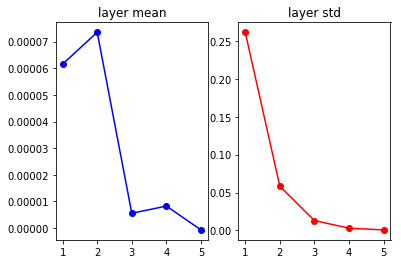

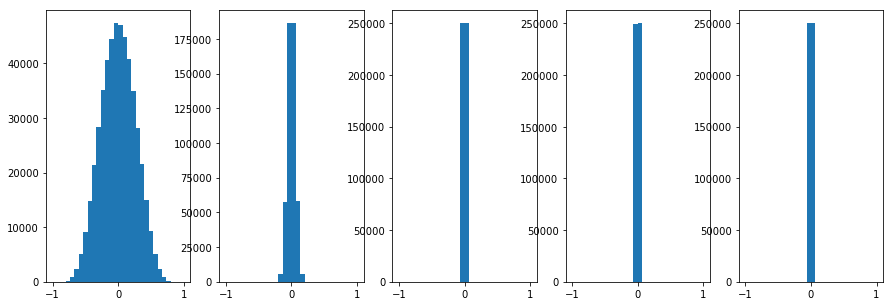

In [14]:
# Small random weights (gaussian with zero mean and small standard deviation)

model_fc_tanh = create_fc_model(input_units=input_units,hidden_units=hidden_units,
                                   output_units=output_units,activation='tanh')

model_init(model_fc_tanh,input_units=input_units,hidden_units=hidden_units,
           w_value='randn',w_scaling=0.01)

hiddens_tanh = [layer.name for layer in model_fc_tanh.layers[:-1]]

Hs_fc_tanh_small = get_layer_outputs(model_fc_tanh,dummy_inputs,layer_name=hiddens_tanh)

print "Tanh activation with small random initialization"

plot_activations(dummy_inputs,Hs_fc_tanh_small,'tanh')

Tanh activation with large random initialization
input layer has mean -0.001637 and std 1.000399
hidden layer 1 has mean 0.000014 and std 0.985614
hidden layer 2 has mean -0.000812 and std 0.981844
hidden layer 3 has mean -0.001494 and std 0.981555
hidden layer 4 has mean 0.003688 and std 0.981534
hidden layer 5 has mean 0.000273 and std 0.981716


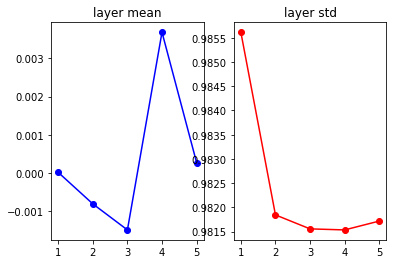

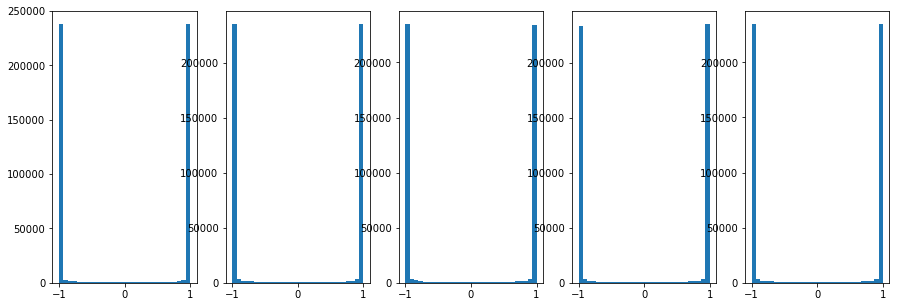

In [15]:
# Large random weights (gaussian with zero mean and large standard deviation)

model_init(model_fc_tanh,input_units=input_units,hidden_units=hidden_units,
           w_value='randn',w_scaling=1)

Hs_fc_tanh_large = get_layer_outputs(model_fc_tanh,dummy_inputs,layer_name=hiddens_tanh)

print "Tanh activation with large random initialization"

plot_activations(dummy_inputs,Hs_fc_tanh_large,'tanh')

Tanh activation with Xavier initialization
input layer has mean -0.001637 and std 1.000399
hidden layer 1 has mean -0.001191 and std 0.627648
hidden layer 2 has mean -0.000144 and std 0.485652
hidden layer 3 has mean 0.000395 and std 0.407334
hidden layer 4 has mean -0.000004 and std 0.357533
hidden layer 5 has mean 0.000110 and std 0.322064


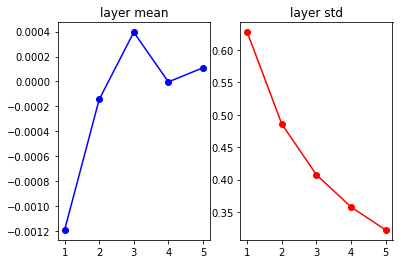

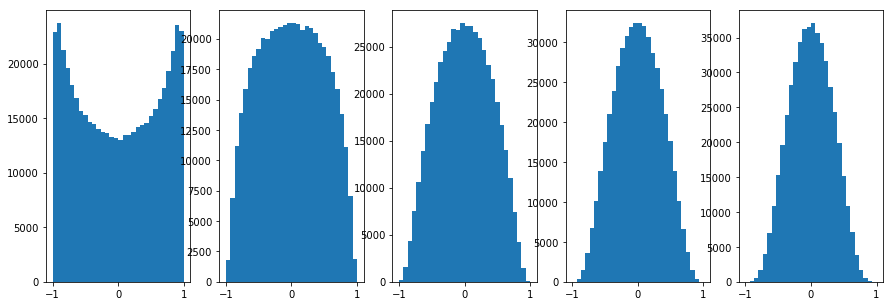

In [16]:
# Xavier weights initialization

model_init(model_fc_tanh,input_units=input_units,hidden_units=hidden_units,
           w_value='xavier',w_scaling=1)

Hs_fc_tanh_xavier = get_layer_outputs(model_fc_tanh,dummy_inputs,layer_name=hiddens_tanh)

print "Tanh activation with Xavier initialization"

plot_activations(dummy_inputs,Hs_fc_tanh_xavier,'tanh')

#### 1.2. weight initialization with relu activation

Relu activation with small random initialization
input layer has mean -0.001637 and std 1.000399
hidden layer 1 has mean 0.112077 and std 0.164017
hidden layer 2 has mean 0.017838 and std 0.025988
hidden layer 3 has mean 0.002764 and std 0.004072
hidden layer 4 has mean 0.000428 and std 0.000634
hidden layer 5 has mean 0.000067 and std 0.000097


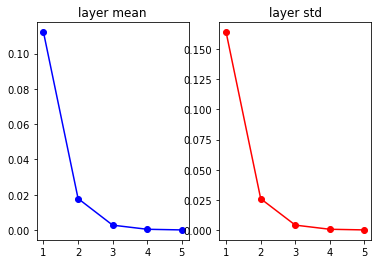

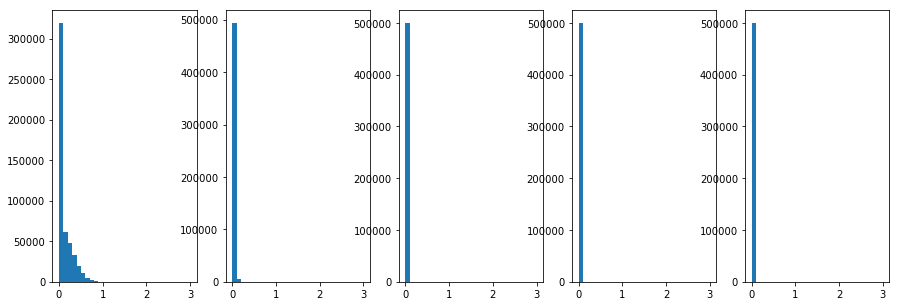

In [17]:
# Small random weights (gaussian with zero mean and small standard deviation)

model_fc_relu = create_fc_model(input_units=input_units,hidden_units=hidden_units,
                                   output_units=output_units,activation='relu')

model_init(model_fc_relu,input_units=input_units,hidden_units=hidden_units,
           w_value='randn',w_scaling=0.01)

hiddens_relu = [layer.name for layer in model_fc_relu.layers[:-1]]

Hs_fc_relu_small = get_layer_outputs(model_fc_relu,dummy_inputs,layer_name=hiddens_relu)

print "Relu activation with small random initialization"

plot_activations(dummy_inputs,Hs_fc_relu_small,'relu')

Relu activation with large random initialization
input layer has mean -0.001637 and std 1.000399
hidden layer 1 has mean 11.183095 and std 16.380568
hidden layer 2 has mean 169.928772 and std 253.922943
hidden layer 3 has mean 2642.359863 and std 3940.097168
hidden layer 4 has mean 39386.281250 and std 60204.339844
hidden layer 5 has mean 605109.375000 and std 906228.062500


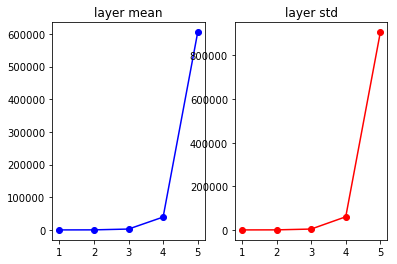

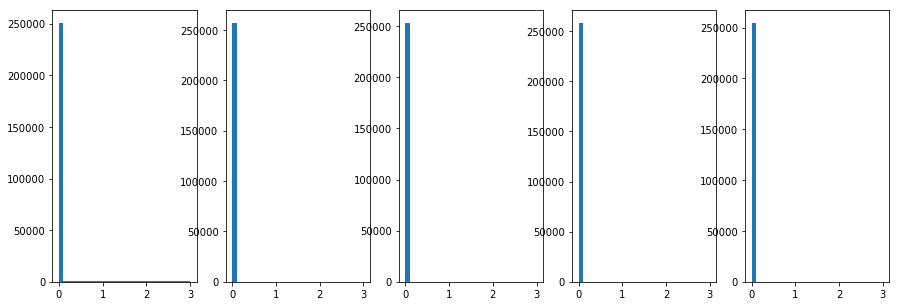

In [18]:
# Large random weights (gaussian with zero mean and large standard deviation)

model_init(model_fc_relu,input_units=input_units,hidden_units=hidden_units,
           w_value='randn',w_scaling=1)

Hs_fc_relu_large = get_layer_outputs(model_fc_relu,dummy_inputs,layer_name=hiddens_relu)

print "Relu activation with large random initialization"

plot_activations(dummy_inputs,Hs_fc_relu_large,'relu')

Relu activation with Xavier initialization
input layer has mean -0.001637 and std 1.000399
hidden layer 1 has mean 0.565456 and std 0.828055
hidden layer 2 has mean 0.579475 and std 0.831999
hidden layer 3 has mean 0.583772 and std 0.830519
hidden layer 4 has mean 0.589049 and std 0.837725
hidden layer 5 has mean 0.567041 and std 0.827144


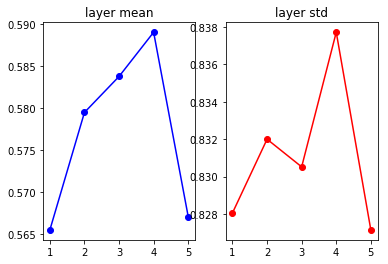

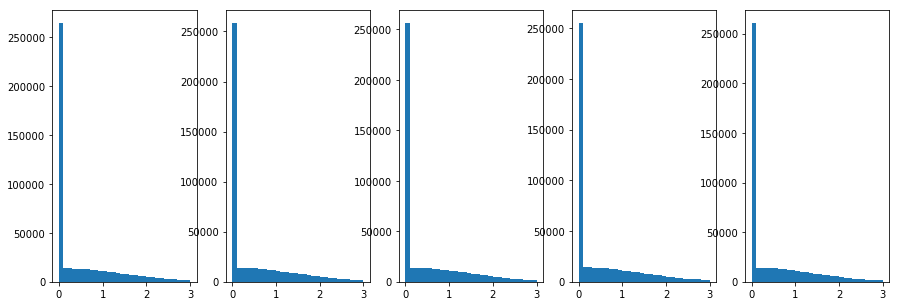

In [19]:
# Xavier weights initialization

model_init(model_fc_relu,input_units=input_units,hidden_units=hidden_units,
           w_value='xavier',w_scaling=np.sqrt(2))

Hs_fc_relu_xavier = get_layer_outputs(model_fc_relu,dummy_inputs,layer_name=hiddens_relu)

print "Relu activation with Xavier initialization"

plot_activations(dummy_inputs,Hs_fc_relu_xavier,'relu') 

#### 1.3. Batch Normalization

In [20]:
# Insert batch normalizaton layers before non-linearities to normalize intermediate data.
model_bn = Sequential()
model_bn.add(Dense(hidden_units,activation='tanh',input_shape=(input_units,)))
model_bn.add(BatchNormalization())
model_bn.add(Dense(hidden_units,activation='tanh'))
model_bn.add(BatchNormalization())
model_bn.add(Dense(hidden_units,activation='tanh'))
model_bn.add(Dense(output_units,activation='softmax'))

model_bn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

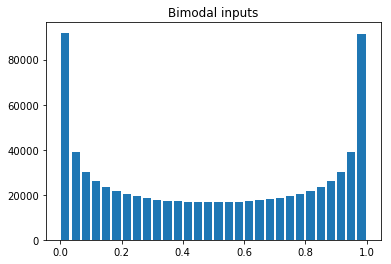

In [21]:
bimodal_inputs = np.random.beta(0.5,0.5,(batch_size,input_units))
plt.hist(bimodal_inputs.ravel(),30,rwidth=0.8)
plt.title('Bimodal inputs')
plt.show()

Batch Normalization
input layer has mean 0.500138 and std 0.353710
hidden layer 1 has mean -0.016493 and std 0.501642
hidden layer 2 has mean 0.000000 and std 0.993195
hidden layer 3 has mean -0.000047 and std 0.626026
hidden layer 4 has mean 0.000000 and std 0.998725
hidden layer 5 has mean 0.000019 and std 0.626911


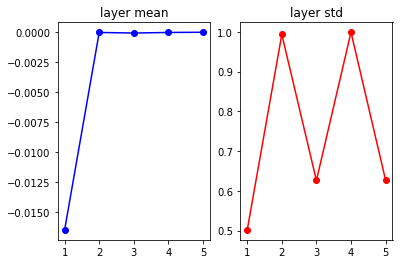

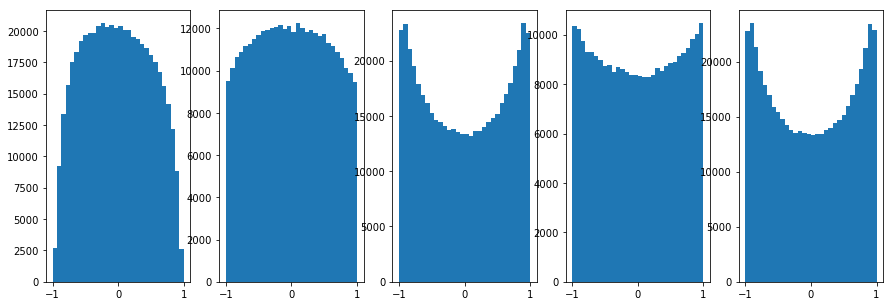

In [22]:
hiddens_bn = [layer.name for layer in model_bn.layers[:-1]]

Hs_bn = get_layer_outputs(model_bn,bimodal_inputs,learning_phase=1,layer_name=hiddens_bn)

print "Batch Normalization"

plot_activations(bimodal_inputs,Hs_bn,'tanh') 

# Notice hidden layer 2 and 4 (batch normalization layers) bring the activation back to standard gaussian

###  Model achitecture: ConvNet

In [23]:
from keras.layers import Conv2D,MaxPooling2D,Flatten
from keras import callbacks

Xtrain_roll = Xtrain.reshape(-1,28,28,1)
Xval_roll = Xval.reshape(-1,28,28,1)
Xtest_roll = Xtest.reshape(-1,28,28,1)

input_reshape = (28,28,1)
pool_size = (2,2)
epochs = 10
batch_size = 32

In [24]:
# Create model
model_conv1 = Sequential()
model_conv1.add(Conv2D(32, kernel_size=(5,5),strides=(1,1),padding='same',activation = 'relu',input_shape=input_reshape))
model_conv1.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model_conv1.add(Conv2D(64,(3,3),padding='same',activation = 'relu'))
model_conv1.add(MaxPooling2D(pool_size=pool_size))
model_conv1.add(Flatten())
model_conv1.add(Dense(1024, activation='relu'))
model_conv1.add(Dense(output_units,activation = 'softmax'))

model_conv1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
import time
fname='weights/conv1.{epoch:02d}-{val_loss:.2f}.h5'
cbks=[callbacks.ModelCheckpoint(filepath=fname,monitor='val_loss',save_best_only=True),
                               callbacks.EarlyStopping(monitor='val_loss',patience=3)]
start_time = time.time()

trained_conv1 = model_conv1.fit(Xtrain_roll,ytrain,batch_size=batch_size,epochs=epochs,
                                callbacks=cbks,validation_data=(Xval_roll,yval))

print "it takes %d minutes to finish" % ((time.time()-start_time)//60)

'import time\nfname=\'weights/conv1.{epoch:02d}-{val_loss:.2f}.h5\'\ncbks=[callbacks.ModelCheckpoint(filepath=fname,monitor=\'val_loss\',save_best_only=True),\n                               callbacks.EarlyStopping(monitor=\'val_loss\',patience=3)]\nstart_time = time.time()\n\ntrained_conv1 = model_conv1.fit(Xtrain_roll,ytrain,batch_size=batch_size,epochs=epochs,\n                                callbacks=cbks,validation_data=(Xval_roll,yval))\n\nprint "it takes %d minutes to finish" % ((time.time()-start_time)//60)'

In [26]:
model_conv1.load_weights('weights/conv1.05-0.04.h5')

In [131]:
def display_activations(layer_info,activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    sample_size = activation_maps[0].shape[0]
    assert sample_size == 1, "One image at a time..."
    for layer_name, activation_map in zip(layer_info,activation_maps):
        print "Display activation map of {}".format(layer_name)
        shape = len(activation_map.shape)
        if shape == 4:
            activation = np.transpose(activation_map[0],(2,0,1))
            square_display(layer_name,activation)
        elif shape == 2:
            if activation_map.shape[1] > 1024:
                side_len = int(np.floor(np.sqrt(activation_map.shape[1])))
                activation_map=activation_map[0][:side_len**2]
                activation = activation_map.reshape((side_len,side_len))
            else:
                activation = activation_map
            plt.imshow(activation)
            plt.title(layer_name)
            plt.show()
        elif shape == 3:
            raise Exception ('len(shape)== 3 not implemented')


In [129]:
def square_display(name,a):
    a=(a-a.min())/(a.max()-a.min())
    n = int(np.ceil(np.sqrt(a.shape[0])))
    a = np.pad(a,((0,n**2-int(a.shape[0])),(0,1),(0,1))+((0, 0),)*(a.ndim-3),
                        mode='constant',constant_values=1)
    a=a.reshape((n,n)+a.shape[1:]).transpose((0,2,1,3)+tuple(range(4,a.ndim+1)))
    a=a.reshape((n*a.shape[1],n*a.shape[3])+a.shape[4:])
    a=np.pad(a,((1,0),(1,0)),mode='constant',constant_values=1)
    plt.figure(figsize=(10,10))
    plt.imshow(a)
    plt.title(name)
    plt.show()
    return

test image of digit 8:


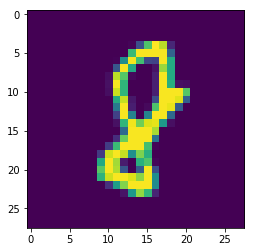

In [138]:
print 'test image of digit 8:'
plt.imshow(np.squeeze(Xtest_roll[0],axis=2))
plt.show()

Display activation map of conv2d_1


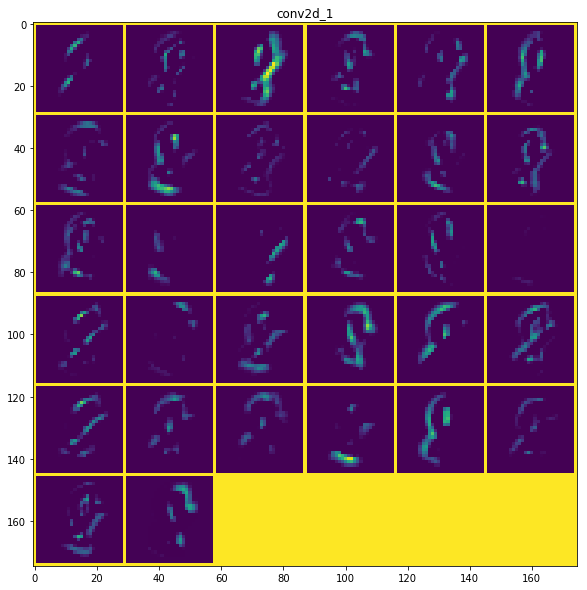

Display activation map of conv2d_2


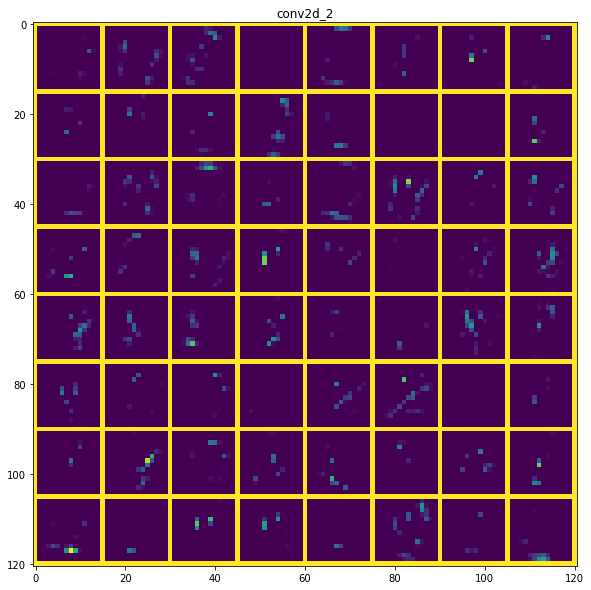

Display activation map of flatten_1


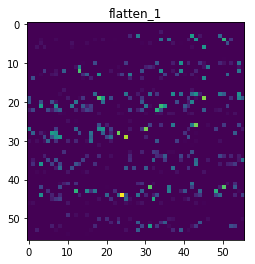

Display activation map of dense_18


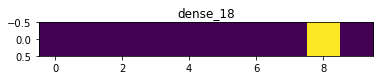

In [139]:
layer_index =[0,2,4,6]
loi = [layer.name for i,layer in enumerate(model_conv1.layers) if i in layer_index]
a = get_layer_outputs(model_conv1,Xtest_roll[:1],layer_name=loi)
display_activations(loi,a)